In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import math
import numpy as np


# Hyperparameters
batch_size = 128
learning_rate = 1e-4
num_epochs = 40
patch_size = 2
num_classes = 10
dim = 1024
depth = 18
heads = 16
mlp_dim = 2048
dropout = 0.0

# CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(dtype= torch.bfloat16)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(dtype= torch.float32)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def pair(t):
    """Ensures that the input is a tuple of length 2."""
    return t if isinstance(t, tuple) else (t, t)

class PatchEmbedding(nn.Module):
    """
    Turns input images into patch embeddings.

    Args:
        in_channels (int): Number of input channels.
        patch_size (int): Size of each patch.
        emb_dim (int): Embedding dimension.

    Input:
        x (tensor): Shape (B, C, H, W)

    Output:
        x (tensor): Shape (B, num_patches, emb_dim)
    """
    def __init__(self, in_channels, patch_size, emb_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, emb_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, emb_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, emb_dim)
        return x

class MultiHeadSelfAttention(nn.Module):
    """
    Multi-head self-attention module.

    Args:
        dim (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        dropout (float): Dropout rate.

    Input:
        x (tensor): Shape (B, N, dim)

    Output:
        out (tensor): Shape (B, N, dim)
    """
    def __init__(self, dim, num_heads, dropout):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.dim = dim

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)

        return out

class FeedForward(nn.Module):
    """
    Feed-forward network with two linear layers and GELU activation.

    Args:
        dim (int): Embedding dimension.
        mlp_dim (int): Hidden dimension of the feed-forward network.
        dropout (float): Dropout rate.

    Input:
        x (tensor): Shape (B, N, dim)

    Output:
        x (tensor): Shape (B, N, dim)
    """
    def __init__(self, dim, mlp_dim, dropout):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(dim, mlp_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)  # (B, N, mlp_dim)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)  # (B, N, dim)
        x = self.drop(x)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block with multi-head self-attention and feed-forward network.

    Args:
        dim (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        mlp_dim (int): Hidden dimension of the feed-forward network.
        dropout (float): Dropout rate.

    Input:
        x (tensor): Shape (B, N, dim)

    Output:
        x (tensor): Shape (B, N, dim)
    """
    def __init__(self, dim, num_heads, mlp_dim, dropout):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class SinusoidalPositionalEncoding(nn.Module):
    """
    Generates sinusoidal positional embeddings.

    Args:
        emb_dim (int): Embedding dimension.
        num_patches (int): Number of patches.

    Output:
        pos_embedding (tensor): Shape (1, num_patches + 1, emb_dim)
    """
    def __init__(self, emb_dim, num_patches, device):
        super(SinusoidalPositionalEncoding, self).__init__()
        self.device = device
        self.embed_dim = emb_dim
        self.num_patches = num_patches

    @staticmethod
    def create_sinusoidal_embeddings(emb_dim, num_positions):
        """Creates sinusoidal embeddings with the specified dimension and number of positions."""
        position = torch.arange(num_positions).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * -(math.log(10000.0) / emb_dim))
        pe = torch.zeros(num_positions, emb_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        pos_embed = self.create_sinusoidal_embeddings(self.embed_dim, self.num_patches).to(self.device)
        return pos_embed

class VisionTransformer(nn.Module):
    """
    Vision Transformer model.

    Args:
        in_channels (int): Number of input channels.
        num_classes (int): Number of classes for classification.
        emb_dim (int): Embedding dimension.
        depth (int): Number of transformer encoder blocks.
        num_heads (int): Number of attention heads.
        mlp_dim (int): Hidden dimension of the feed-forward network.
        patch_size (int): Size of each patch.
        dropout (float): Dropout rate.

    Input:
        x (tensor): Shape (B, C, H, W)

    Output:
        x (tensor): Shape (B, num_classes)
    """
    def __init__(self, in_channels, num_classes, emb_dim, depth, num_heads, mlp_dim, patch_size, dropout, neural_process=False, permute=False):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        # self.pos_embed = SinusoidalPositionalEncoding(emb_dim, (32 // patch_size) ** 2 + 1, device=device)
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, (32 // patch_size) ** 2 + 1, emb_dim))
        self.pos_embed.to(device)
        self.pos_drop = nn.Dropout(p=dropout)

        self.transformer = nn.ModuleList([
            TransformerEncoder(emb_dim, num_heads, mlp_dim, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)
        self.neural_process = neural_process
        self.representation = nn.MultiheadAttention(
            embed_dim=emb_dim,
            num_heads=num_heads,
            batch_first=True,
            device=device,
        )
        self.permute = permute

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, num_patches, emb_dim)
        # Permute axis 1
        permute = np.random.permutation(x.shape[1])
        # Permute axis 1 at every iteration. If the representation is permutatio
        # invariant, the model should be able to learn the correct representation.
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, emb_dim)

        # cls_pos_embed = torch.zeros_like(cls_tokens)[0:1]
        # full_pos_embed = torch.cat((cls_pos_embed, self.pos_embed), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        if self.permute:
            x = x[:, permute, :]

        for layer in self.transformer:
            x = layer(x)  # (B, num_patches + 1, emb_dim)

        if self.neural_process:
            cls_token_final = self.representation(
                key=x[:, 1:, :],
                query=x[:, 0, :].unsqueeze(1),
                value=x[:, 1:, :],
            )[0].squeeze(1)  # (B, emb_dim)
        else:
            cls_token_final = x[:, 0]  # (B, emb_dim)
        x = self.norm(x)
        x = self.head(cls_token_final)  # (B, num_classes)
        return x

def train(model, train_loader, criterion, optimizer, num_epochs):
    """
    Trains the Vision Transformer model.

    Args:
        model (nn.Module): Vision Transformer model.
        train_loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        num_epochs (int): Number of epochs.

    No return value.
    """
    model.train()
    model.to(dtype=torch.bfloat16)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # (B, num_classes)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

def test(model, test_loader):
    """
    Tests the Vision Transformer model.

    Args:
        model (nn.Module): Vision Transformer model.
        test_loader (DataLoader): DataLoader for test data.

    No return value. Prints accuracy.
    """
    model.eval()
    model.to(dtype=torch.float32)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # (B, num_classes)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


import matplotlib.pyplot as plt
def check_calibration(model, test_loader, n_bins=10):
    """
    Checks the calibration of the Vision Transformer model by plotting a reliability diagram
    and calculating the Expected Calibration Error (ECE).

    Args:
        model (nn.Module): Vision Transformer model.
        test_loader (DataLoader): DataLoader for test data.
        n_bins (int): Number of bins to use for the calibration plot and ECE calculation.

    Returns:
        ece (float): Expected Calibration Error.
    """
    model.eval()
    model.to(dtype=torch.float32)
    confidences = []
    predictions = []
    actuals = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.Softmax(dim=1)(outputs)
            confidence, prediction = torch.max(probs, 1)
            confidences.extend(confidence.cpu().numpy())
            predictions.extend(prediction.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    confidences = np.array(confidences)
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Reliability diagram
    bins = np.linspace(0.1, 1.0, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    accuracies = np.zeros(n_bins)
    avg_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])
        bin_counts[i] = np.sum(in_bin)
        if bin_counts[i] > 0:
            accuracies[i] = np.mean(predictions[in_bin] == actuals[in_bin])
            avg_confidences[i] = np.mean(confidences[in_bin])

    # Plot reliability diagram
    plt.figure(figsize=(8, 8))
    plt.plot(avg_confidences, accuracies, marker='o', linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle='-', color='gray')
    plt.title('Reliability Diagram')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Calculate Expected Calibration Error (ECE)
    ece = np.sum((bin_counts / np.sum(bin_counts)) * np.abs(avg_confidences - accuracies))
    print(f'Expected Calibration Error (ECE): {ece:.4f}')

    return ece


/vol/bitbucket/ad6013/anaconda3/envs/np_causal_discovery_3.8/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/vol/bitbucket/ad6013/anaconda3/envs/np_causal_discovery_3.8/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [1/40], Loss: 2.2010


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [2/40], Loss: 1.5912


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [3/40], Loss: 1.3728


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [4/40], Loss: 1.2258


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [5/40], Loss: 1.1208


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [6/40], Loss: 1.0445


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [7/40], Loss: 0.9662


100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch [8/40], Loss: 0.8726


100%|██████████| 391/391 [02:49<00:00,  2.30it/s]


Epoch [9/40], Loss: 0.7886


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [10/40], Loss: 0.6820


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [11/40], Loss: 0.5768


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [12/40], Loss: 0.4624


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [13/40], Loss: 0.3270


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [14/40], Loss: 0.2255


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [15/40], Loss: 0.1422


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [16/40], Loss: 0.0522


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [17/40], Loss: 0.0097


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [18/40], Loss: 0.0027


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [19/40], Loss: 0.0021


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [20/40], Loss: 0.0019


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [21/40], Loss: 0.0018


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [22/40], Loss: 0.0017


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [23/40], Loss: 0.0017


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [24/40], Loss: 0.0016


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [25/40], Loss: 0.0016


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [26/40], Loss: 0.0015


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [27/40], Loss: 0.0015


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [28/40], Loss: 0.0015


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [29/40], Loss: 0.0015


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [30/40], Loss: 0.0015


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [31/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [32/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [33/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [34/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [35/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch [36/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [37/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [38/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [39/40], Loss: 0.0014


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch [40/40], Loss: 0.0014
Accuracy of the model on the test images: 64.33%


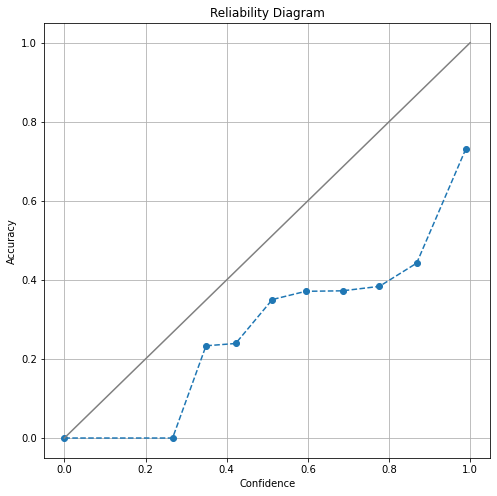

Expected Calibration Error (ECE): 0.2741


0.27407303127646443

In [2]:
np.random.seed(0)
torch.manual_seed(0)
# Run the training and testing
model = VisionTransformer(
    in_channels=3,
    num_classes=num_classes,
    emb_dim=dim,
    depth=depth,
    num_heads=heads,
    mlp_dim=mlp_dim,
    patch_size=patch_size,
    dropout=0,
    neural_process=False,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

train(model, train_loader, criterion, optimizer, num_epochs)
test(model, test_loader)
# Check the calibration
check_calibration(model, test_loader, n_bins=10)


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [1/40], Loss: 1.9313


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [2/40], Loss: 1.4733


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [3/40], Loss: 1.2768


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [4/40], Loss: 1.1437


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [5/40], Loss: 1.0326


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [6/40], Loss: 0.9532


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [7/40], Loss: 0.8575


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [8/40], Loss: 0.7657


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [9/40], Loss: 0.6861


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [10/40], Loss: 0.6103


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [11/40], Loss: 0.5182


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [12/40], Loss: 0.4297


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [13/40], Loss: 0.3440


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [14/40], Loss: 0.2370


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [15/40], Loss: 0.1713


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [16/40], Loss: 0.0578


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [17/40], Loss: 0.0125


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [18/40], Loss: 0.0060


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [19/40], Loss: 0.0052


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [20/40], Loss: 0.0047


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [21/40], Loss: 0.0044


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [22/40], Loss: 0.0042


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [23/40], Loss: 0.0040


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [24/40], Loss: 0.0039


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [25/40], Loss: 0.0038


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [26/40], Loss: 0.0037


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [27/40], Loss: 0.0036


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [28/40], Loss: 0.0036


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [29/40], Loss: 0.0035


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [30/40], Loss: 0.0035


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [31/40], Loss: 0.0034


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [32/40], Loss: 0.0034


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [33/40], Loss: 0.0034


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [34/40], Loss: 0.0033


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [35/40], Loss: 0.0033


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [36/40], Loss: 0.0033


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [37/40], Loss: 0.0033


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [38/40], Loss: 0.0032


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [39/40], Loss: 0.0032


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [40/40], Loss: 0.0032
Accuracy of the model on the test images: 70.65%


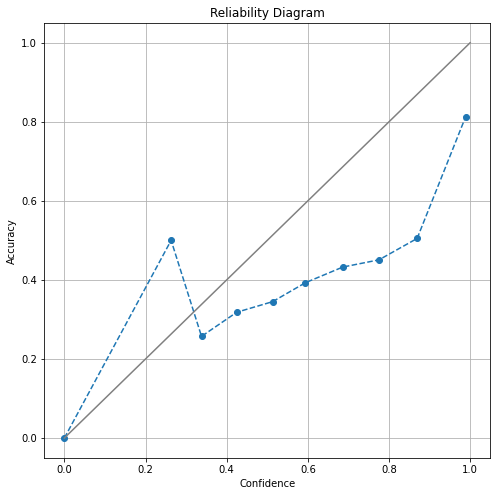

Expected Calibration Error (ECE): 0.2021


0.202082402998209

In [3]:
np.random.seed(0)
torch.manual_seed(0)
# Run the training and testing
model = VisionTransformer(
    in_channels=3,
    num_classes=num_classes,
    emb_dim=dim,
    depth=depth,
    num_heads=heads,
    mlp_dim=mlp_dim,
    patch_size=patch_size,
    dropout=dropout,
    neural_process=True,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, criterion, optimizer, num_epochs)
test(model, test_loader)
# Check the calibration
check_calibration(model, test_loader, n_bins=10)

100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [1/40], Loss: 2.0006


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [2/40], Loss: 1.4474


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [3/40], Loss: 1.2528


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [4/40], Loss: 1.1312


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [5/40], Loss: 1.0388


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [6/40], Loss: 0.9535


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [7/40], Loss: 0.8879


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [8/40], Loss: 0.8308


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [9/40], Loss: 0.7637


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [10/40], Loss: 0.7066


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [11/40], Loss: 0.6495


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [12/40], Loss: 0.5987


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [13/40], Loss: 0.5398


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [14/40], Loss: 0.4922


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [15/40], Loss: 0.4409


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [16/40], Loss: 0.3989


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [17/40], Loss: 0.3472


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [18/40], Loss: 0.3066


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [19/40], Loss: 0.2671


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [20/40], Loss: 0.2402


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [21/40], Loss: 0.2177


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [22/40], Loss: 0.2058


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [23/40], Loss: 0.1681


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [24/40], Loss: 0.1597


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [25/40], Loss: 0.1652


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [26/40], Loss: 0.1502


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [27/40], Loss: 0.1358


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [28/40], Loss: 0.1235


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [29/40], Loss: 0.1261


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [30/40], Loss: 0.1166


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [31/40], Loss: 0.1135


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [32/40], Loss: 0.1115


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [33/40], Loss: 0.1018


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [34/40], Loss: 0.1009


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [35/40], Loss: 0.1077


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [36/40], Loss: 0.0997


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [37/40], Loss: 0.0855


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [38/40], Loss: 0.0933


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [39/40], Loss: 0.0903


100%|██████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch [40/40], Loss: 0.0876
Accuracy of the model on the test images: 68.28%


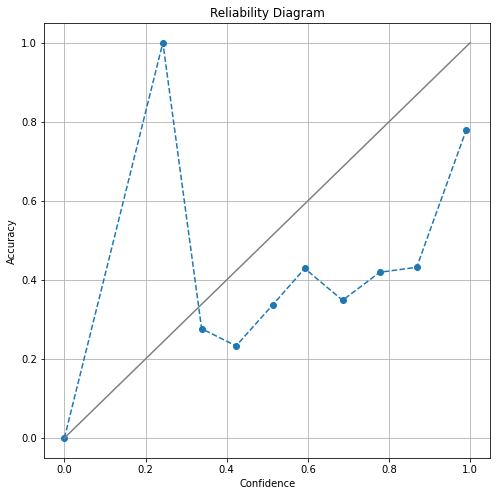

Expected Calibration Error (ECE): 0.2354


0.23541768580675126

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
# Run the training and testing
model = VisionTransformer(
    in_channels=3,
    num_classes=num_classes,
    emb_dim=dim,
    depth=depth,
    num_heads=heads,
    mlp_dim=mlp_dim,
    patch_size=patch_size,
    dropout=dropout,
    neural_process=False,
    permute=True,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, criterion, optimizer, num_epochs)
test(model, test_loader)
check_calibration(model, test_loader, n_bins=10)

  0%|          | 0/391 [00:00<?, ?it/s]

100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [1/40], Loss: 1.8026


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [2/40], Loss: 1.3906


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [3/40], Loss: 1.2092


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [4/40], Loss: 1.1029


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [5/40], Loss: 1.0149


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [6/40], Loss: 0.9331


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [7/40], Loss: 0.8696


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [8/40], Loss: 0.8118


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [9/40], Loss: 0.7612


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [10/40], Loss: 0.7078


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [11/40], Loss: 0.6592


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [12/40], Loss: 0.6476


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [13/40], Loss: 0.6003


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [14/40], Loss: 0.5572


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [15/40], Loss: 0.5308


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [16/40], Loss: 0.5261


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [17/40], Loss: 0.4785


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [18/40], Loss: 0.4640


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [19/40], Loss: 0.4316


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [20/40], Loss: 0.4557


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [21/40], Loss: 0.4483


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [22/40], Loss: 0.4597


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [23/40], Loss: 0.3964


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [24/40], Loss: 0.3634


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [25/40], Loss: 0.3415


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [26/40], Loss: 0.3423


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [27/40], Loss: 0.4506


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [28/40], Loss: 0.6805


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [29/40], Loss: 0.4726


100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


Epoch [30/40], Loss: 0.4111


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [31/40], Loss: 0.3758


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [32/40], Loss: 0.6485


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [33/40], Loss: 0.4571


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [34/40], Loss: 0.3730


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [35/40], Loss: 0.4087


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [36/40], Loss: 0.3623


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [37/40], Loss: 0.4802


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [38/40], Loss: 0.4374


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [39/40], Loss: 0.3512


100%|██████████| 391/391 [02:20<00:00,  2.79it/s]


Epoch [40/40], Loss: 0.3893
Accuracy of the model on the test images: 67.89%


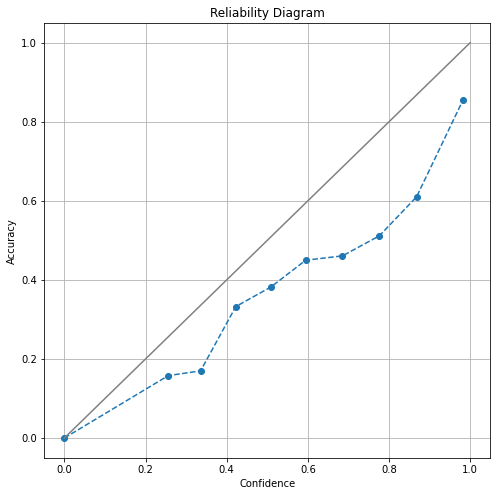

Expected Calibration Error (ECE): 0.1602


0.16022815529704096

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
# Run the training and testing
model = VisionTransformer(
    in_channels=3,
    num_classes=num_classes,
    emb_dim=dim,
    depth=depth,
    num_heads=heads,
    mlp_dim=mlp_dim,
    patch_size=patch_size,
    dropout=dropout,
    neural_process=True,
    permute=True,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, criterion, optimizer, num_epochs)
test(model, test_loader)
check_calibration(model, test_loader, n_bins=10)